In [5]:
import mxnet as mx
import numpy as np
import pandas as pd

In [6]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
(a, b, c)

(<Symbol a>, <Symbol b>, <Symbol _plus0>)

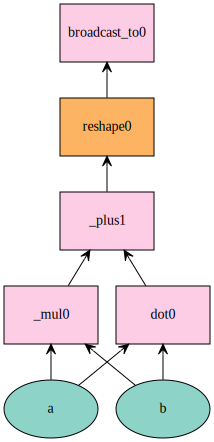

In [7]:
# elemental wise multiplication
d = a * b
# matrix multiplication
e = mx.sym.dot(a, b)
# reshape
f = mx.sym.reshape(d+e, shape=(1,4))
# broadcast
g = mx.sym.broadcast_to(f, shape=(2,4))
# plot
mx.viz.plot_network(symbol=g)

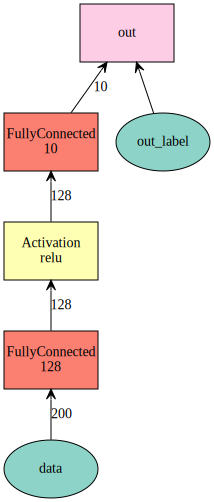

In [8]:
# Basic Neural Network
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net, shape={'data':(100, 200)})

In [9]:
# Retrieve arguments
# These arguments are the parameters and inpuuts needed by each symbol
# - data: Input data needed by the variable data
# - fc1_weight and fc1_bias: The weight and bias for the first fully connected layer fc1
# - fc2_weight and fc2_bias: The weight and bias for the second fully connected layer fc2
# - out_label: The label needed by the loss
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

In [10]:
# Another way tgo specify the names explicitly
net = mx.symbol.Variable('data')
w = mx.symbol.Variable('myweight')
net = mx.symbol.FullyConnected(data=net, weight=w, name='fc1', num_hidden=128)
net.list_arguments()

['data', 'myweight', 'fc1_bias']

In [11]:
# An element-wise add between two symbols
lhs = mx.symbol.Variable('data1')
rhs = mx.symbol.Variable('data2')
net = mx.symbol.FullyConnected(data=lhs+rhs, name='fc1', num_hidden=128)
net.list_arguments()

['data1', 'data2', 'fc1_weight', 'fc1_bias']

In [12]:
# connect two nets
data = mx.symbol.Variable('data')
net1 = mx.symbol.FullyConnected(data=data, name='fc1', num_hidden=10)
net1.list_arguments()
net2 = mx.symbol.Variable('data2')
net2 = mx.symbol.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed')
composed.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias']

In [13]:
# Prefix NameManager to build bigger networks
data = mx.sym.Variable('data')
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix('layer%d_'%(i+1)):
        net = mx.sym.FullyConnected(data=net, name='fc', num_hidden=100)
mx.sym.SoftmaxOutput(data=net, name='out')
net.list_arguments()

['data',
 'layer1_fc_weight',
 'layer1_fc_bias',
 'layer2_fc_weight',
 'layer2_fc_bias']

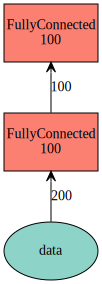

In [14]:
mx.viz.plot_network(net, shape={'data':(100,200)})

In [15]:
# Modularized Construction for Deep Networks
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0,0), name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel,
                             stride=stride, pad=pad, name='conv_%s%s' %(name,suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_%s%s' %(name, suffix))
    return act
prev = mx.sym.Variable(name='Previous Output')
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2,2))
shape = {'Previous Output': (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape).view()

'plot.gv.pdf'

In [16]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3,
                      pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape).view()

'plot.gv.pdf'

In [17]:
# Group Multiple Symbols
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type='relu')
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()

['softmax_output', 'regression_output']

In [18]:
arg_name = c.list_arguments()  # get the names of the inputs
out_name = c.list_outputs()    # get the names of the outputs
# infers output shape given the shape of input arguments
arg_shape, out_shape, _ = c.infer_shape(a=(2,3), b=(2,3))
# infers output type given the type of input arguments
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')
{'input' : dict(zip(arg_name, arg_shape)),
 'output' : dict(zip(out_name, out_shape))}
{'input' : dict(zip(arg_name, arg_type)),
 'output' : dict(zip(out_name, out_type))}

{'input': {'a': numpy.float32, 'b': numpy.float32},
 'output': {'_plus0_output': numpy.float32}}

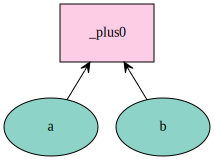

In [19]:
mx.viz.plot_network(c)

In [20]:
# Bind with data and Evaluate
ex = c.bind(ctx=mx.cpu(0), args={'a':mx.nd.ones([2,3]), 
                                 'b':mx.nd.ones([2,3])})
ex.forward()
print('number of outputs = %d \nthe first output = \n%s' %(len(ex.outputs), 
                                                           ex.outputs[0].asnumpy()))

number of outputs = 1 
the first output = 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


In [21]:
gpu_device = mx.gpu() # change this to mx.cpu() in absence of GPUs.
ex_gpu = c.bind(ctx=gpu_device, args={'a':mx.nd.ones([3,4], gpu_device)*2,
                                      'b':mx.nd.ones([3,4], gpu_device)*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

array([[ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.]], dtype=float32)

In [22]:
# use eval method to evaluate the symbol
ex = c.eval(ctx = mx.gpu(0), a = mx.nd.ones([2,3], mx.gpu(0)), b = mx.nd.ones([2,3], mx.gpu(0)))
print('number of ouputs = %d\nthe first output = \n%s' %(len(ex), ex[0].asnumpy()))

number of ouputs = 1
the first output = 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


In [23]:
# Load and Save
print(c.tojson())


{
  "nodes": [
    {
      "op": "null", 
      "name": "a", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "b", 
      "inputs": []
    }, 
    {
      "op": "elemwise_add", 
      "name": "_plus0", 
      "inputs": [[0, 0, 0], [1, 0, 0]]
    }
  ], 
  "arg_nodes": [0, 1], 
  "node_row_ptr": [0, 1, 2, 3], 
  "heads": [[2, 0, 0]], 
  "attrs": {"mxnet_version": ["int", 1000]}
}


In [27]:
c.save('symbol-c.json')
c2 = mx.sym.load('symbol-c.json')
c.tojson() == c2.tojson()

True

In [30]:
# Type cast
a = mx.sym.Variable('data')
b = mx.sym.cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
print({'input':arg, 'output':out})

c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print({'input':arg, 'output':out})


{'output': [<class 'numpy.float16'>], 'input': [<class 'numpy.float32'>]}
{'output': [<class 'numpy.uint8'>], 'input': [<class 'numpy.int32'>]}


In [31]:
# Variable Sharing
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b = a + a * a

data = mx.nd.ones((2,3))*2
ex = b.bind(ctx=mx.cpu(), args={'a':data, 'b':data})
ex.forward()
ex.outputs[0].asnumpy()


array([[ 6.,  6.,  6.],
       [ 6.,  6.,  6.]], dtype=float32)